In [1]:
import subprocess
import sys

In [2]:
# Define the command
command = ['python', 'run_program.py', 'inputdata/3056.jpg', 'detail', '800']

# Run the command and capture output
process = subprocess.Popen(
    command,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    universal_newlines=True
)

# Get the output
stdout, stderr = process.communicate()

# Print the output
print("Standard Output:")
print(stdout)

if stderr:
    print("\nStandard Error:")
    print(stderr)

Standard Output:

Converting image...
Input JPG: d:\Project\sc_cuda2\inputdata\3056.jpg
Temp PPM: d:\Project\sc_cuda2\temp\temp_input.pnm
Successfully converted d:\Project\sc_cuda2\inputdata\3056.jpg to d:\Project\sc_cuda2\temp\temp_input.pnm
File exists: True
File size: 64068817 bytes

Running seam_carving_seq.exe...
Running command: seam_carving_seq.exe d:\Project\sc_cuda2\temp\temp_input.pnm d:\Project\sc_cuda2\temp\detail 800
Image size (width x height): 3056 x 1847

Number of seam removed: 800


Seam Carving Performance Analysis:
---------------------------------
Grayscale conversion: 10.69 ms
Backward energy (Sobel): 68895.16 ms
Forward energy: 49719.08 ms
Hybrid energy: 10588.69 ms
Dynamic programming: 3859.46 ms
Seam tracing and removal: 6027.80 ms
---------------------------------
Total seam carving time: 141658.06 ms

Image size after seam carving (new_width x height): 2256 x 1847

Successfully converted d:\Project\sc_cuda2\temp\detail_seq.pnm to d:\Project\sc_cuda2\output\de

In [3]:
# This cell should be run after the command completes
# It will parse the output and extract the performance metrics
import re

def extract_metrics(output):
    metrics = {}
    current_impl = None
    
    for line in output.split('\n'):
        if 'Running seam_carving_' in line:
            current_impl = line.split('seam_carving_')[1].split('.exe')[0]
            metrics[current_impl] = {}
        elif 'Grayscale conversion:' in line:
            metrics[current_impl]['Grayscale conversion'] = float(line.split(':')[1].strip().split()[0])
        elif 'Backward energy (Sobel):' in line:
            metrics[current_impl]['Backward energy (Sobel)'] = float(line.split(':')[1].strip().split()[0])
        elif 'Forward energy:' in line:
            metrics[current_impl]['Forward energy'] = float(line.split(':')[1].strip().split()[0])
        elif 'Hybrid energy:' in line:
            metrics[current_impl]['Hybrid energy'] = float(line.split(':')[1].strip().split()[0])
        elif 'Dynamic programming:' in line:
            metrics[current_impl]['Dynamic programming'] = float(line.split(':')[1].strip().split()[0])
        elif 'Seam tracing and removal:' in line:
            metrics[current_impl]['Seam tracing and removal'] = float(line.split(':')[1].strip().split()[0])
        elif 'Total seam carving time:' in line:
            metrics[current_impl]['Total time'] = float(line.split(':')[1].strip().split()[0])
    
    return metrics

# Parse the metrics from the output
performance_data = extract_metrics(stdout)
print("Extracted Performance Metrics:")
print(performance_data)

Extracted Performance Metrics:
{'seq': {'Grayscale conversion': 10.69, 'Backward energy (Sobel)': 68895.16, 'Forward energy': 49719.08, 'Hybrid energy': 10588.69, 'Dynamic programming': 3859.46, 'Seam tracing and removal': 6027.8, 'Total time': 141658.06}, 'omp': {'Grayscale conversion': 2.9, 'Backward energy (Sobel)': 14662.84, 'Forward energy': 15759.77, 'Hybrid energy': 2991.7, 'Dynamic programming': 8168.52, 'Seam tracing and removal': 8761.17, 'Total time': 75215.51}, 'cuda': {'Grayscale conversion': 0.42, 'Backward energy (Sobel)': 331.06, 'Forward energy': 295.85, 'Hybrid energy': 369.26, 'Dynamic programming': 2118.72, 'Seam tracing and removal': 3115.11, 'Total time': 11241.45}, 'mpi': {'Grayscale conversion': 10.26, 'Backward energy (Sobel)': 26194.57, 'Forward energy': 21701.92, 'Hybrid energy': 4715.76, 'Dynamic programming': 3969.86, 'Seam tracing and removal': 5058.47, 'Total time': 77363.48}}


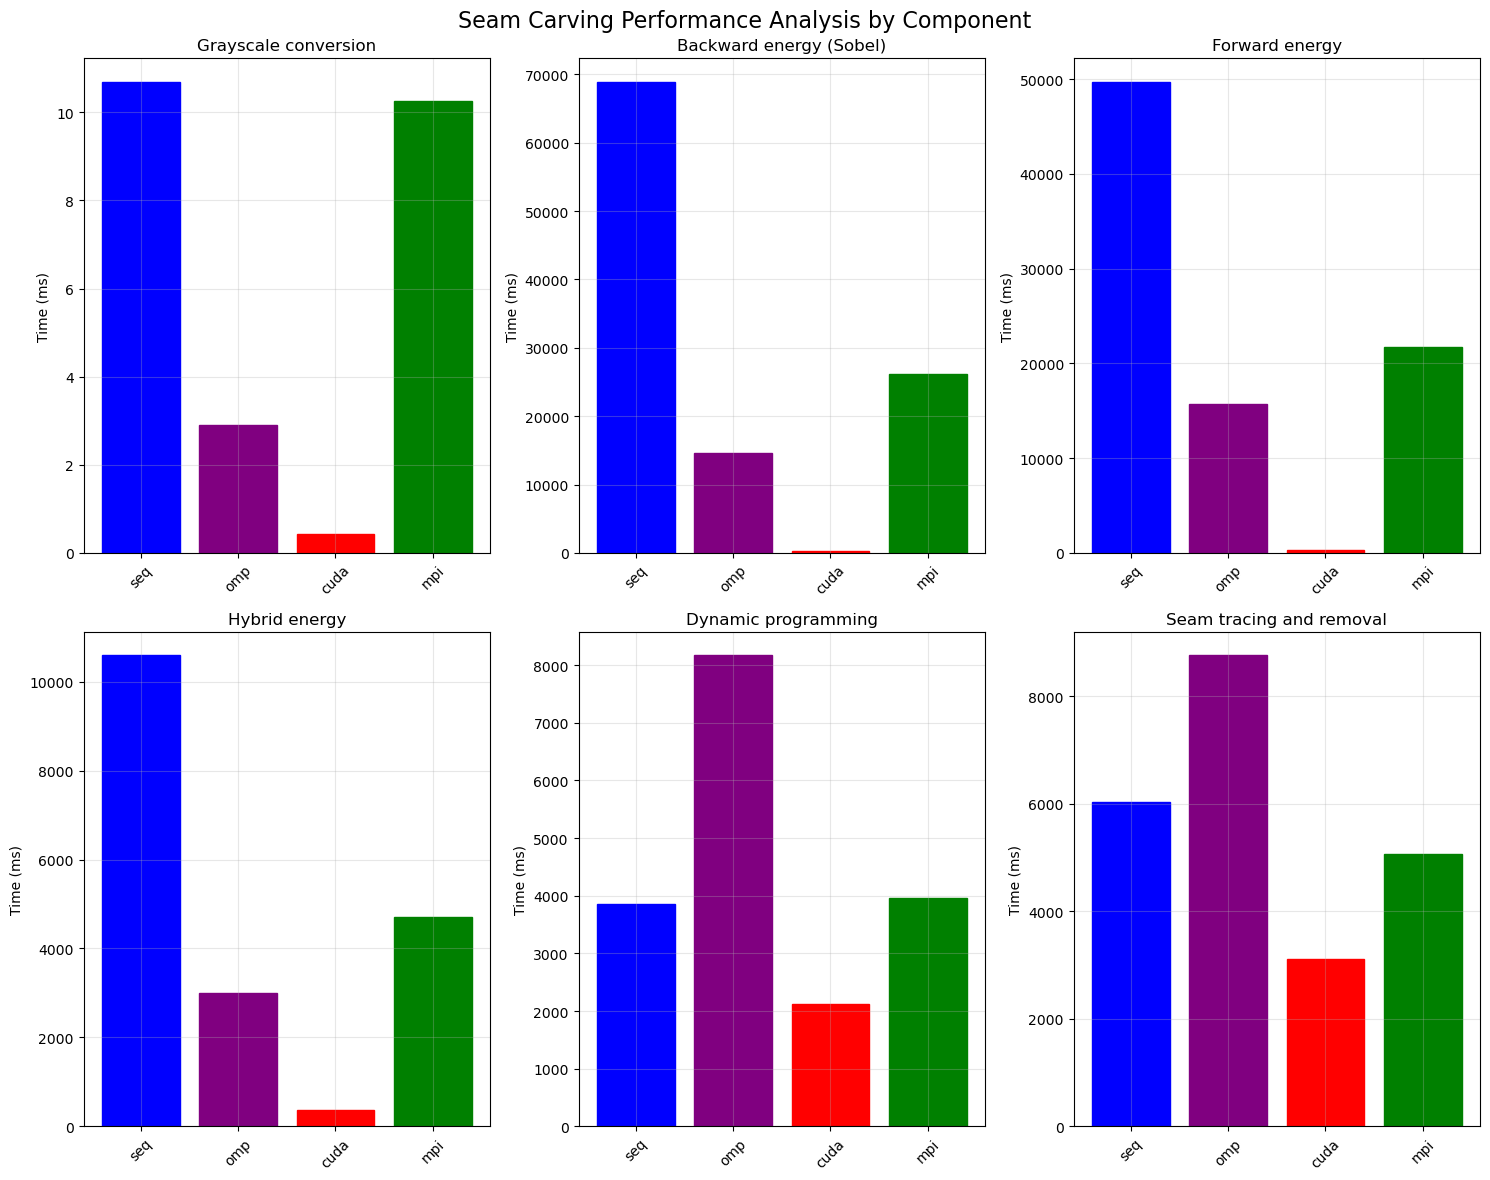

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Define colors for each implementation
colors = {
    'sequential': 'blue',
    'omp': 'purple', 
    'cuda': 'red',
    'mpi': 'green'
}

# Convert to DataFrame
df = pd.DataFrame(performance_data)

# Remove 'Total time' for individual component analysis
components = df.index[:-1]

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Seam Carving Performance Analysis by Component', fontsize=16)

# Plot for each component
for i, (component, ax) in enumerate(zip(components, axes.flat)):
    bars = ax.bar(df.columns, df.loc[component])
    # Set color for each bar based on implementation
    for bar, impl in zip(bars, df.columns):
        # Map implementation name to color
        if impl == 'seq':
            bar.set_color(colors['sequential'])
        else:
            bar.set_color(colors[impl])
    ax.set_title(f'{component}')
    ax.set_ylabel('Time (ms)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

# Remove empty subplot if any
if len(components) < len(axes.flat):
    fig.delaxes(axes.flat[-1])

plt.tight_layout()
plt.show()

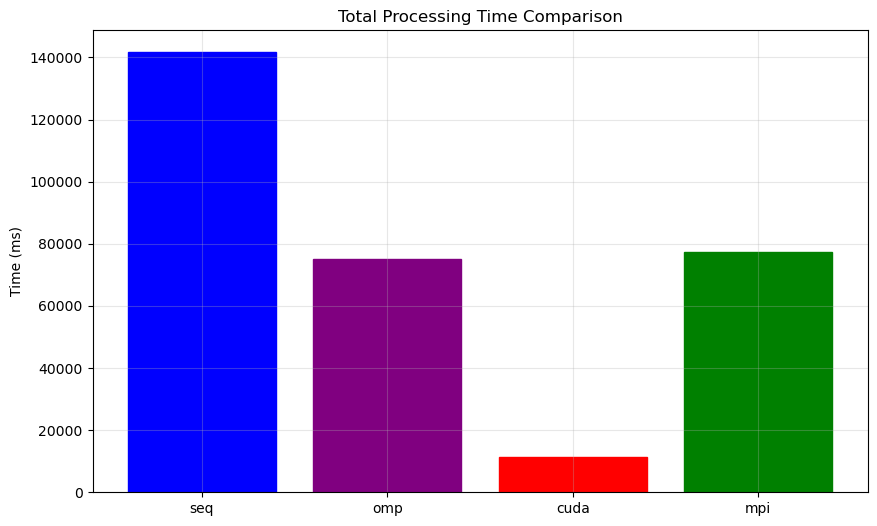

In [12]:
# Plot total times comparison
plt.figure(figsize=(10, 6))
total_times = [df[impl]['Total time'] for impl in df.columns]
bars = plt.bar(df.columns, total_times)
# Set color for each bar based on implementation
for bar, impl in zip(bars, df.columns):
    # Map implementation name to color
    if impl == 'seq':
        bar.set_color(colors['sequential'])
    else:
        bar.set_color(colors[impl])
plt.title('Total Processing Time Comparison')
plt.ylabel('Time (ms)')
plt.grid(True, alpha=0.3)
plt.show()

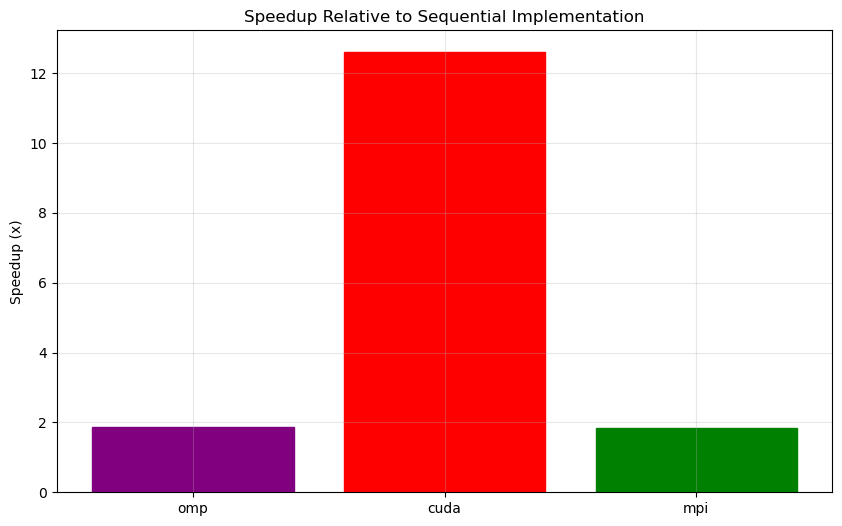

In [13]:
# Calculate speedup relative to sequential implementation
sequential_time = df['seq']['Total time']
speedup = {
    impl: sequential_time / df[impl]['Total time']
    for impl in df.columns
    if impl != 'seq'
}

plt.figure(figsize=(10, 6))
bars = plt.bar(speedup.keys(), speedup.values())
# Set color for each bar based on implementation
for bar, impl in zip(bars, speedup.keys()):
    bar.set_color(colors[impl])
plt.title('Speedup Relative to Sequential Implementation')
plt.ylabel('Speedup (x)')
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# Calculate throughput (seams per second)
def calculate_throughput(seams_removed, total_time_ms):
    return seams_removed / (total_time_ms / 1000)  # Convert ms to seconds

# Number of seams removed (from your command: 800)
seams_removed = 800

# Calculate throughput for each implementation
throughput_data = {
    impl: calculate_throughput(seams_removed, df[impl]['Total time'])
    for impl in df.columns
}

print("Throughput (seams per second):")
for impl, throughput in throughput_data.items():
    print(f"{impl}: {throughput:.2f} seams/second")

Throughput (seams per second):
seq: 5.65 seams/second
omp: 10.64 seams/second
cuda: 71.17 seams/second
mpi: 10.34 seams/second


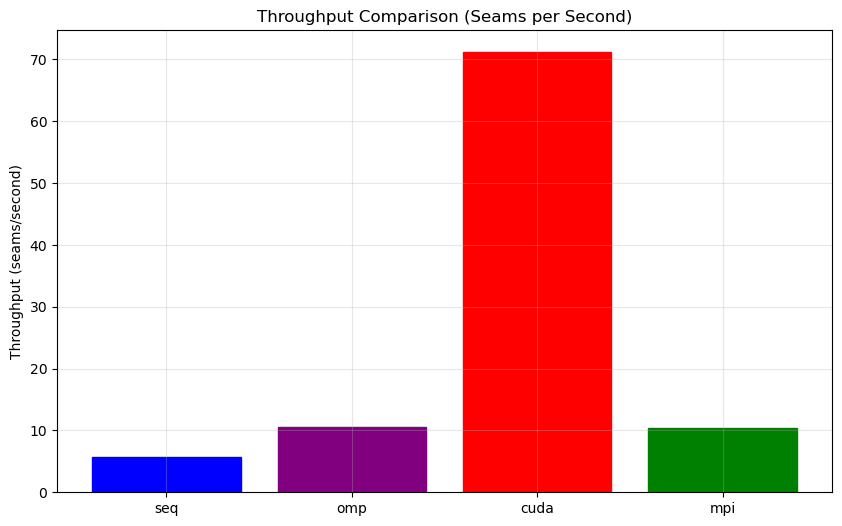

In [18]:
# Plot throughput comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(throughput_data.keys(), throughput_data.values())
# Set color for each bar based on implementation
for bar, impl in zip(bars, throughput_data.keys()):
    if impl == 'seq':
        bar.set_color(colors['sequential'])
    else:
        bar.set_color(colors[impl])
plt.title('Throughput Comparison (Seams per Second)')
plt.ylabel('Throughput (seams/second)')
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# Create a comprehensive performance metrics table
performance_table = pd.DataFrame({
    'Implementation': list(df.columns),
    'Total Time (ms)': [df[impl]['Total time'] for impl in df.columns],
    'Throughput (seams/s)': [throughput_data[impl] for impl in df.columns],
    'Speedup': [1.0] + [sequential_time / df[impl]['Total time'] for impl in df.columns if impl != 'seq']
})

# Format the table for better readability
performance_table['Total Time (ms)'] = performance_table['Total Time (ms)'].round(2)
performance_table['Throughput (seams/s)'] = performance_table['Throughput (seams/s)'].round(2)
performance_table['Speedup'] = performance_table['Speedup'].round(2)

print("\nComprehensive Performance Metrics:")
print(performance_table.to_string(index=False))


Comprehensive Performance Metrics:
Implementation  Total Time (ms)  Throughput (seams/s)  Speedup
           seq        141658.06                  5.65     1.00
           omp         75215.51                 10.64     1.88
          cuda         11241.45                 71.17    12.60
           mpi         77363.48                 10.34     1.83
